In [ ]:
! pip install python-Levenshtein

In [ ]:
import numpy as np
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import lru_cache
from Levenshtein import distance as levenshtein_distance
from collections import defaultdict
import numpy as np

# Прочтение таблиц

In [ ]:
data = pd.read_csv("/content/The_Wide_Pirate.tsv")
data.head()

,Rank\tRead.count\tRead.proportion\tCDR3.nucleotide.sequence\tCDR3.amino.acid.sequence\tbestVGene\tbestJGene
0,0\t4120\t0.00224331836880263\tTGTGCCAGCAGCAACA...
1,1\t3579\t0.00194874670920986\tTGTGCCAGCAGCCGCC...
2,2\t3304\t0.00179901065303978\tTGTGCCAGCAGTCCTA...
3,3\t3281\t0.00178648727379646\tTGTGCCAGCAGTTCCC...
4,4\t2908\t0.00158339073215487\tTGTGCCAGCAGTGAGG...


In [ ]:
df = pd.DataFrame(data)
df.columns = ['data']
df['CDR3.amino.acid.sequence'] = df['data'].str.split('\t').str[4]
df['Read.proportion'] = df['data'].str.split('\t').str[2]
df['Read.proportion'] = pd.to_numeric(df['Read.proportion'])
df['Read.count'] = df['data'].str.split('\t').str[1]
df['bestVGene'] = df['data'].str.split('\t').str[5]
df['bestJGene'] = df['data'].str.split('\t').str[6]
del df['data']
df

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene
0,CASSNSDRTYGDNEQFF,2.243318e-03,4120,TRBV6-2,TRBJ2-1
1,CASSRRHLGNTGELFF,1.948747e-03,3579,TRBV7-2,TRBJ2-2
2,CASSPSTDTQYF,1.799011e-03,3304,TRBV27,TRBJ2-3
3,CASSSRGLANTQYF,1.786487e-03,3281,TRBV12-4,TRBJ2-3
4,CASSEGRSNQPQHF,1.583391e-03,2908,TRBV2,TRBJ1-5
...,...,...,...,...,...
982149,FFIFFVLVVLAYEQYF,5.444947e-07,1,TRBV27,TRBJ2-7
982150,FFSVPPAFFS_GGGGGGQFF,5.444947e-07,1,TRBV7-5,TRBJ2-1
982151,FFCSSIIAGEKQEAQFF,5.444947e-07,1,TRBV18,TRBJ2-5
982152,FFFSCVLVHDTLFF,5.444947e-07,1,TRBV7-6,TRBJ2-5


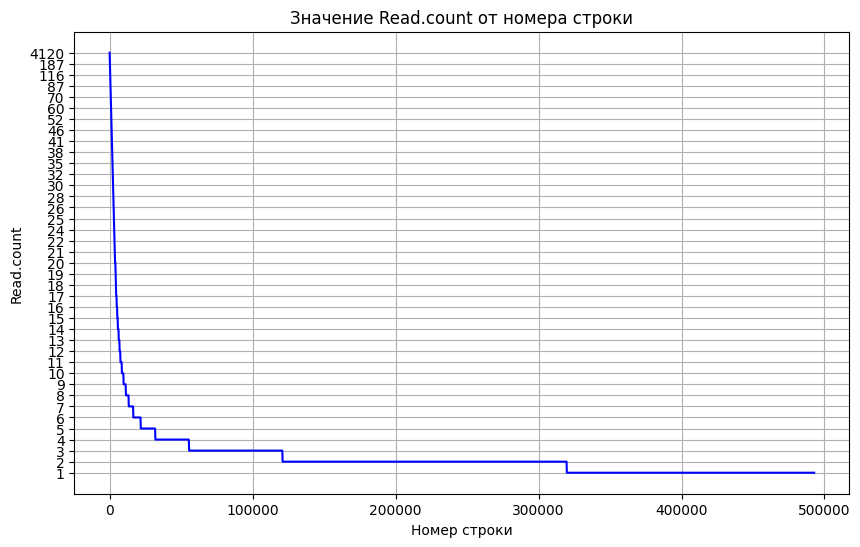

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[::200], df['Read.count'][::200], linestyle='-', color='b')
plt.xlabel('Номер строки')
plt.ylabel('Read.count')
plt.title('Значение Read.count от номера строки')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

In [ ]:
index_30 = df[df['Read.count'] == '40'].index
print(index_30)

Index([1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654,
       1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666,
       1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678,
       1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690,
       1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701],
      dtype='int64')


In [ ]:
database = pd.read_excel("/content/vdjdb_slim.xlsx")

In [ ]:
database_exp = database.rename(columns={'cdr3': 'CDR3.amino.acid.sequence'})

In [ ]:
data_claster = df[:1643]
data_claster

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene
0,CASSNSDRTYGDNEQFF,0.002243,4120,TRBV6-2,TRBJ2-1
1,CASSRRHLGNTGELFF,0.001949,3579,TRBV7-2,TRBJ2-2
2,CASSPSTDTQYF,0.001799,3304,TRBV27,TRBJ2-3
3,CASSSRGLANTQYF,0.001786,3281,TRBV12-4,TRBJ2-3
4,CASSEGRSNQPQHF,0.001583,2908,TRBV2,TRBJ1-5
...,...,...,...,...,...
1638,CASRPRGTGGIDEQFF,0.000022,41,TRBV6-2,TRBJ2-1
1639,CASSIPGPGNTIYF,0.000022,41,TRBV3-1,TRBJ1-3
1640,CAISQQGKYEQYV,0.000022,41,TRBV10-3,TRBJ2-7
1641,CAIPLAGSNTGELFF,0.000022,41,TRBV10-3,TRBJ2-2


# Функция кластеризации

In [ ]:
# Кэшированная функция для вычисления расстояния Левенштейна
@lru_cache(maxsize=None)
def cached_levenshtein_distance(seq1, seq2):
    return levenshtein_distance(seq1, seq2)

# Функция для кластеризации последовательностей
def cluster_sequences(sequences, max_distance=1):
    clusters = []
    for seq in sequences:
        added_to_cluster = False
        for cluster in clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for existing_seq in cluster):
                cluster.append(seq)
                added_to_cluster = True
                break
        if not added_to_cluster:
            clusters.append([seq])
    return clusters

# Функция для объединения кластеров
def merge_clusters(clusters, max_distance=1):
    merged_clusters = []
    for cluster in clusters:
        added_to_cluster = False
        for merged_cluster in merged_clusters:
            if any(cached_levenshtein_distance(seq, existing_seq) <= max_distance for seq in cluster for existing_seq in merged_cluster):
                merged_cluster.extend(cluster)
                added_to_cluster = True
                break
        if not added_to_cluster:
            merged_clusters.append(cluster)
    return merged_clusters

# Пример последовательностей аминокислот
sequences = data_claster['CDR3.amino.acid.sequence']

# Разделение данных на части
chunk_size = len(sequences) // 100
chunks = [sequences[i:i + chunk_size] for i in range(0, len(sequences), chunk_size)]

# Кластеризация каждой части
all_clusters = []
for chunk in chunks:
    all_clusters.extend(cluster_sequences(chunk, max_distance=1))

# Объединение кластеров
final_clusters = merge_clusters(all_clusters, max_distance=1)

# Вывод результатов
# Создание DataFrame
cluster_data = []
for i, cluster in enumerate(final_clusters):
    for seq in cluster:
        cluster_data.append({'Cluster': i + 1, 'Sequence': seq})

results_df = pd.DataFrame(cluster_data)

In [ ]:
# Создание нового DataFrame с данными из data_claster и номером кластера
cluster_assignments = {}
for i, cluster in enumerate(final_clusters):
  for seq in cluster:
    cluster_assignments[seq] = i + 1

results_df = data_claster.copy()
results_df['Cluster'] = results_df['CDR3.amino.acid.sequence'].map(cluster_assignments)

# Вывод нового DataFrame results_df
results_df


,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene,Cluster
0,CASSNSDRTYGDNEQFF,0.002243,4120,TRBV6-2,TRBJ2-1,1
1,CASSRRHLGNTGELFF,0.001949,3579,TRBV7-2,TRBJ2-2,2
2,CASSPSTDTQYF,0.001799,3304,TRBV27,TRBJ2-3,3
3,CASSSRGLANTQYF,0.001786,3281,TRBV12-4,TRBJ2-3,4
4,CASSEGRSNQPQHF,0.001583,2908,TRBV2,TRBJ1-5,5
...,...,...,...,...,...,...
1638,CASRPRGTGGIDEQFF,0.000022,41,TRBV6-2,TRBJ2-1,1572
1639,CASSIPGPGNTIYF,0.000022,41,TRBV3-1,TRBJ1-3,1573
1640,CAISQQGKYEQYV,0.000022,41,TRBV10-3,TRBJ2-7,1574
1641,CAIPLAGSNTGELFF,0.000022,41,TRBV10-3,TRBJ2-2,1575


# Подсчёт Total Read Proportion

In [ ]:
# Подсчет суммарного Read.proportion для каждого кластера
cluster_proportions = {}
cluster_counts = {}
for index, row in data_claster.iterrows():
  seq = row['CDR3.amino.acid.sequence']
  proportion = row['Read.proportion']
  for i, cluster in enumerate(final_clusters):
    if seq in cluster:
      cluster_proportions[i + 1] = cluster_proportions.get(i + 1, 0) + proportion
      cluster_counts[i + 1] = cluster_counts.get(i + 1, 0) + 1
      break

# Создание DataFrame с суммарными пропорциями, номерами кластеров и количеством последовательностей
proportions_data = []
for cluster_number, total_proportion in cluster_proportions.items():
  proportions_data.append({'Cluster': cluster_number,
               'Total Read Proportion': total_proportion,
               'Sequence Count': cluster_counts[cluster_number]})



# Сортировка по Sequence Count

In [ ]:
proportions_df = pd.DataFrame(proportions_data)
proportions_df = proportions_df.sort_values(by='Sequence Count', ascending=False)
proportions_df

,Cluster,Total Read Proportion,Sequence Count
172,173,0.000413,7
142,143,0.000296,5
2,3,0.001931,4
234,235,0.000217,4
550,551,0.000108,3
...,...,...,...
536,537,0.000051,1
535,536,0.000051,1
534,535,0.000051,1
533,534,0.000051,1


# Сортировка по Total Read Proportion

In [ ]:
proportions_df_sorted = proportions_df.sort_values(by='Total Read Proportion', ascending=False)
proportions_df_sorted = proportions_df_sorted.loc[proportions_df_sorted['Sequence Count'] > 1]
proportions_df_sorted
print(len(proportions_df_sorted))

47


# Выбор кластера

In [ ]:
results_df = results_df.rename(columns={'Sequence': 'CDR3.amino.acid.sequence'})

In [ ]:
full = pd.merge(results_df, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,28,CASSLWTGGHNEQFF,0.000386,TRBV28,TRBJ2-1,TRBV5-6*01,TRBJ2-1*01,MHCI,HomoSapiens,CMV,IE1
1,103,CASSLGGGAYEQYF,0.000171,TRBV12-4,TRBJ2-7,TRBV5-4*01,TRBJ2-7*01,MHCI,HomoSapiens,HomoSapiens,GANAB
2,103,CASSLGGGAYEQYF,0.000171,TRBV12-4,TRBJ2-7,TRBV18*01,TRBJ2-7*01,MHCI,HomoSapiens,SARS-CoV-2,RNP
3,105,CASSLDTDTQYF,0.000164,TRBV7-2,TRBJ2-3,TRBV7-9*01,TRBJ2-3*01,MHCI,HomoSapiens,EBV,BMLF1
4,105,CASSLDTDTQYF,0.000164,TRBV7-2,TRBJ2-3,TRBV5-1*01,TRBJ2-3*01,MHCI,HomoSapiens,CMV,pp65
...,...,...,...,...,...,...,...,...,...,...,...
75,1530,CASSIRSSHEQYF,0.000023,TRBV19,TRBJ2-7,TRBV19*01,TRBJ2-7*01,MHCI,HomoSapiens,InfluenzaA,M
76,1539,CASSSSGTAYGYTF,0.000022,TRBV5-1,TRBJ1-2,TRBV6-3*01,TRBJ1-2*01,MHCI,HomoSapiens,YFV,NS4B
77,619,CASSLSESSYNEQFF,0.000022,TRBV7-9,TRBJ2-1,TRBV5-1*01,TRBJ2-1*01,MHCI,HomoSapiens,HomoSapiens,MLANA
78,619,CASSLSESSYNEQFF,0.000022,TRBV7-9,TRBJ2-1,TRBV7-9*01,TRBJ2-1*01,MHCI,HomoSapiens,EBV,EBNA4


In [ ]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])]
full_vj

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
8,149,CASSEDGMNTEAFF,0.000123,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,LMP2A
9,149,CASSEDGMNTEAFF,0.000123,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
10,149,CASSEDGMNTEAFF,0.000123,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
13,235,CASSLSGNTEAFF,0.000091,TRBV7-9,TRBJ1-1,TRBV7-9*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
14,374,CSAPLAGGPNEQFF,0.000066,TRBV20-1,TRBJ2-1,TRBV20-1*01,TRBJ2-1*01,MHCI,HomoSapiens,YFV,NS4B
17,439,CASSQDLAGGTDTQYF,0.000058,TRBV4-2,TRBJ2-3,TRBV4-2*01,TRBJ2-3*01,MHCI,HomoSapiens,Mtb,Rv1734c
18,464,CSVGGSFYGYTF,0.000056,TRBV29-1,TRBJ1-2,TRBV29-1*01,TRBJ1-2*01,MHCI,HomoSapiens,EBV,BMLF1
19,473,CSVGTGGTNEKLFF,0.000055,TRBV29-1,TRBJ1-4,TRBV29-1*01,TRBJ1-4*01,MHCI,HomoSapiens,EBV,BMLF1
20,473,CSVGTGGTNEKLFF,0.000055,TRBV29-1,TRBJ1-4,TRBV29-1*01,TRBJ1-4*01,MHCII,HomoSapiens,InfluenzaA,NP
22,522,CASSDRDTGELFF,0.000052,TRBV6-4,TRBJ2-2,TRBV6-4*01,TRBJ2-2*01,MHCI,HomoSapiens,CMV,IE1


In [ ]:
full_vj['Cluster'].value_counts()

,count
Cluster,
149,4
235,3
473,2
374,1
439,1
464,1
522,1
602,1
987,1


In [48]:
cluster_sums = full_vj.drop_duplicates(subset=['Cluster', 'CDR3.amino.acid.sequence']).groupby('Cluster')['Read.proportion'].sum()
cluster_149_sum = cluster_sums[149]
total_sum = cluster_sums.sum()
result = cluster_149_sum / total_sum

print(f"Read.proportion кластера 149, деленная на суммарную Read.proportion всех кластеров: {result}")
print(result*0.5)

Read.proportion кластера 149, деленная на суммарную Read.proportion всех кластеров: 0.2125340599454947
0.10626702997274735


# Обработка для одного выбранного кластера

In [ ]:
results_df_one_cluster = results_df.loc[results_df['Cluster'] == 149]
results_df_one_cluster = results_df_one_cluster.rename(columns={'Sequence': 'CDR3.amino.acid.sequence'})
results_df_one_cluster

,CDR3.amino.acid.sequence,Read.proportion,Read.count,bestVGene,bestJGene,Cluster
149,CASSEDGMNTEAFF,0.000123,225,TRBV10-2,TRBJ1-1,149
389,CASSEDGNTEAFF,0.000065,119,TRBV6-4,TRBJ1-1,149
598,CASSGDGMNTEAFF,0.000047,87,TRBV10-2,TRBJ1-1,149


In [ ]:
full = pd.merge(results_df_one_cluster, database_exp , on='CDR3.amino.acid.sequence', how='inner')

In [ ]:
full = full[['Cluster', 'CDR3.amino.acid.sequence', 'Read.proportion', 'bestVGene',	'bestJGene', 'v.segm',	'j.segm', 'mhc.class', 'species', 'antigen.species', 'antigen.gene']]
full

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,149,CASSEDGMNTEAFF,0.000123,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,LMP2A
1,149,CASSEDGMNTEAFF,0.000123,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
2,149,CASSEDGMNTEAFF,0.000123,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
3,149,CASSGDGMNTEAFF,0.000047,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,LMP2A


In [ ]:
full['antigen.species'].value_counts()

,count
antigen.species,
EBV,2
CMV,2


In [ ]:
full_vj = full.loc[(full['bestVGene'].str[:7] == full['v.segm'].str[:7]) & (full['bestJGene'].str[:7] == full['j.segm'].str[:7])]
full_vj

,Cluster,CDR3.amino.acid.sequence,Read.proportion,bestVGene,bestJGene,v.segm,j.segm,mhc.class,species,antigen.species,antigen.gene
0,149,CASSEDGMNTEAFF,0.000123,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,LMP2A
1,149,CASSEDGMNTEAFF,0.000123,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,IE1
2,149,CASSEDGMNTEAFF,0.000123,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,CMV,pp65
3,149,CASSGDGMNTEAFF,0.000047,TRBV10-2,TRBJ1-1,TRBV10-2*01,TRBJ1-1*01,MHCI,HomoSapiens,EBV,LMP2A
